In [143]:
# import des constantes necessaires
from scipy.constants import Avogadro, c, m_e, m_p,e
# m_e = m_e/(c**2)
# m_p = m_p/(c**2)
import numpy as np # get down babyyyyy
import matplotlib.pyplot as plt # beaux graphiques stylé
m_p = m_p  * 1e-6/e
m_e = m_e  * 1e-6/e
m_e

5.6856301035657226e-18

# Q1
Exprimez la densité électronique $n_e$ d’un milieu en fonction de sa composition atomique et de sa masse volumique $\rho$, et calculer $n_e$ pour l’eau (liquide) et l’os compact (définition de l’ICRU). On s’appuiera sur les données du NIST pour les compositions atomiques de ces matériaux.

In [144]:
# fonction pour le calcul de n_e, source : chatgpt
n_e = lambda atomic_numbers, fractions_by_weight, rho, A: rho * Avogadro * np.sum(atomic_numbers * fractions_by_weight/A)

rho_bone = 1.85 #g/cm^3
atomic_numbers_bone = np.array([1, 6, 7, 8, 12, 15, 16, 20])
fractions_by_weight_bone = np.array([0.063984, 0.278000, 0.027000, 0.410016, 0.002000, 0.070000, 0.002000, 0.147000])
A_bone = np.array([1.008, 12.011, 14.007, 15.999, 24.305, 30.974, 32.065, 40.078])
I_bone = 91.9 * 1e-6 # MeV

n_e_bone = n_e(atomic_numbers_bone, fractions_by_weight_bone, rho_bone, A_bone)

rho_water = 1
I_water = 75 * 1e-6 # MeV
A_water = np.array([1.008, 15.999])
atomic_numbers_water = np.array([1, 8])
fractions_by_weight_water = np.array([0.111894, 0.888106])

n_e_water = n_e(atomic_numbers_water, fractions_by_weight_water, rho_water, A_water)

# Q2

In [145]:
def stopping_power_col(beta, gamma, n_e, I_MeV, T_max):

    # Constants
    r_e = 2.81794e-13  # Classical electron radius (cm)


    # Compute the stopping power
    S_col = (2 * np.pi * r_e**2 * m_e * c**2 * n_e) / (beta**2+np.finfo(np.float64).eps) * (
        np.log(np.finfo(np.float64).eps + (2 * m_e * c**2 * beta**2 * gamma**2 * T_max) / I_MeV**2) - 2 * beta**2)

    return S_col


In [162]:
def T_max_e(gamma):
    """
    Calculate T_max^e, the maximum energy transferable to an electron by a proton.

    Parameters:
        gamma (float): Lorentz factor (1 / sqrt(1 - beta^2)).

    Returns:
        float: Maximum transferable energy T_max^e (MeV).
    """


    # Calculate coefficients
    a = 2 * m_e * c**2
    b = 1 + (m_e / m_p)**2
    delta = 2 * (m_e / m_p)

    # Calculate T_max^e
    T_max = (a * (gamma**2 - 1)) / (b + delta * gamma)
    return T_max

beta = np.linspace(0,1,1000)
beta
gamma = 1 / np.sqrt(1 - beta**2 + np.finfo(np.float64).eps)
T_max = T_max_e(gamma)
T = (gamma - 1)*m_p * c**2

S_col_water = stopping_power_col(beta, gamma, n_e_water, I_water, T_max)
S_col_bone = stopping_power_col(beta, gamma, n_e_bone, I_bone, T_max)

print(f"Stopping Power S_col_bone: {S_col_bone} MeV/cm")
print(f"Stopping Power S_col_water: {S_col_water} MeV/cm")

Stopping Power S_col_bone: [-2.44419726e+16 -1.35169397e+06 -2.33762739e+05 -7.68144908e+04
 -3.24004965e+04 -1.53711541e+04 -7.63020573e+03 -3.71488079e+03
 -1.59007709e+03 -3.82307044e+02  3.23641552e+02  7.40942451e+02
  9.85802781e+02  1.12466494e+03  1.19700943e+03  1.22704307e+03
  1.22999247e+03  1.21563617e+03  1.19035845e+03  1.15838044e+03
  1.12251791e+03  1.08465848e+03  1.04606829e+03  1.00759265e+03
  9.69789279e+02  9.33018038e+02  8.97502088e+02  8.63369968e+02
  8.30684820e+02  7.99464813e+02  7.69697513e+02  7.41350020e+02
  7.14376143e+02  6.88721474e+02  6.64326976e+02  6.41131500e+02
  6.19073540e+02  5.98092438e+02  5.78129196e+02  5.59126996e+02
  5.41031527e+02  5.23791154e+02  5.07356992e+02  4.91682906e+02
  4.76725453e+02  4.62443805e+02  4.48799636e+02  4.35757004e+02
  4.23282226e+02  4.11343745e+02  3.99912007e+02  3.88959333e+02
  3.78459798e+02  3.68389117e+02  3.58724535e+02  3.49444726e+02
  3.40529691e+02  3.31960674e+02  3.23720071e+02  3.15791354e+0

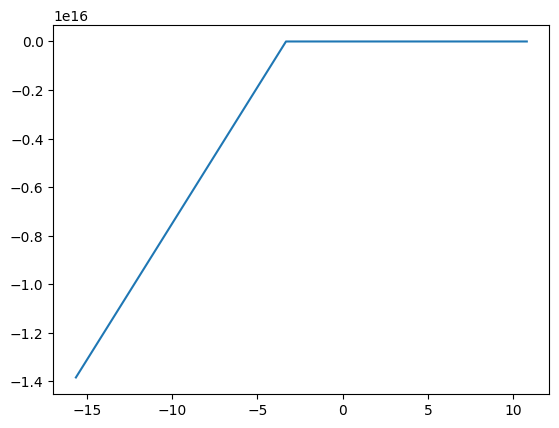

In [183]:
plt.plot(np.log10(T + np.finfo(np.float64).eps), S_col_water)

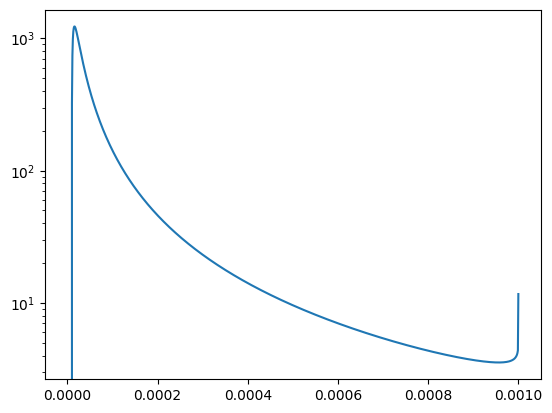

In [159]:
plt.semilogy(beta/1000,S_col_bone)

In [110]:
n_e_water

3.342810286137214e+23

In [111]:
n_e_bone

5.905875865014682e+23

In [112]:
m_p

1.67262192369e-27

In [113]:
m_e

9.1093837015e-31

# Q3


Les données PSTAR sont données ici : https://physics.nist.gov/PhysRefData/Star/Text/PSTAR.html.


In [ ]:
# Données sous forme de chaîne brute
data = """
3.000E+00 1.172E+02
3.500E+00 1.042E+02
4.000E+00 9.404E+01
4.500E+00 8.586E+01
5.000E+00 7.911E+01
5.500E+00 7.343E+01
6.000E+00 6.858E+01
6.500E+00 6.438E+01
7.000E+00 6.071E+01
7.500E+00 5.747E+01
8.000E+00 5.460E+01
8.500E+00 5.202E+01
9.000E+00 4.969E+01
9.500E+00 4.759E+01
1.000E+01 4.567E+01
1.250E+01 3.815E+01
1.500E+01 3.292E+01
1.750E+01 2.905E+01
2.000E+01 2.607E+01
2.500E+01 2.175E+01
2.750E+01 2.013E+01
3.000E+01 1.876E+01
3.500E+01 1.656E+01
4.000E+01 1.488E+01
4.500E+01 1.354E+01
5.000E+01 1.245E+01
5.500E+01 1.154E+01
6.000E+01 1.078E+01
6.500E+01 1.013E+01
7.000E+01 9.559E+00
7.500E+01 9.063E+00
8.000E+01 8.625E+00
8.500E+01 8.236E+00
9.000E+01 7.888E+00
9.500E+01 7.573E+00
1.000E+02 7.289E+00
1.250E+02 6.192E+00
1.500E+02 5.445E+00
1.750E+02 4.903E+00
2.000E+02 4.492E+00
2.250E+02 4.170E+00
2.500E+02 3.911E+00
2.750E+02 3.698E+00
3.000E+02 3.520E+00
3.500E+02 3.241E+00
4.000E+02 3.032E+00
4.500E+02 2.871E+00
5.000E+02 2.743E+00
5.500E+02 2.640E+00
6.000E+02 2.556E+00
6.500E+02 2.485E+00
7.000E+02 2.426E+00
7.500E+02 2.376E+00
8.000E+02 2.333E+00
8.500E+02 2.296E+00
9.000E+02 2.264E+00
9.500E+02 2.236E+00
1.000E+03 2.211E+00
1.500E+03 2.070E+00
2.000E+03 2.021E+00
2.500E+03 2.004E+00
"""

#Convertir en listes.

lignes = data.strip().split("\n")

Ke_Mev = []
Stopping_power_total = []

for ligne in lignes:
    col1, col2 = map(float, ligne.split())
    Ke_Mev.append(col1)
    Stopping_power_total.append(col2)